In [1]:
import tensorflow as tf
from tensorflow.keras.layers import (Layer, 
                                     Dense,
                                     LayerNormalization, 
                                     Dropout,
                                     Input,
                                     Flatten)
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Define the TransformerBlock class
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()

        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training, mask=None):
        attn_output = self.att(inputs, inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        return self.layernorm2(out1 + ffn_output)

In [3]:
# Load the data set
data = pd.read_csv('stock_prices.csv')
data = data[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# prepare the data for training
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0] # slice a sequence from data
        X.append(a) # append the sequence to x
        Y.append(data[i + time_step, 0]) # append the next value to Y
    return np.array(X), np.array(Y)

time_step = 60
X, Y = create_dataset(data, time_step)

In [4]:
# Print to debug and understand the shapes
print("Length of data:", len(data))
print("Length of X:", len(X))
print("Shape of first element in X:", X[0].shape if len(X) > 0 else "X is empty")
print("Shape of Y:", Y.shape)

# Reshape X to fit LSTM input shape requirements (if X is not empty)
if len(X) > 0:
    X = X.reshape(X.shape[0], X.shape[1], 1)
    print("Shape of X after reshape:", X.shape)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Length of data: 2000
Length of X: 1939
Shape of first element in X: (60,)
Shape of Y: (1939,)
Shape of X after reshape: (1939, 60, 1)
Shape of X: (1939, 60, 1)
Shape of Y: (1939,)


In [5]:
input_shape = (X.shape[1], X.shape[2])
inputs = Input(shape=input_shape)

#Embedding layer
x = Dense(128)(inputs)

# Transformer blocks
for _ in range(4):
    x = TransformerBlock(embed_dim=128, num_heads=4, ff_dim=512)(x,training=True)

# Output layer
x = Flatten()(x)
outputs = Dense(1)(x)

# Cretate the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, Y, epochs=20, batch_size=32)


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 7.2073
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.1890
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.1642
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.1392
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.1108
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.1327
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0705
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0594
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0481
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0434
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0377
Epoch 12/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0426
Epoch 13/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0249
Epoch 14/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0225
Epoch 15/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0155
Ep

# Evaluating the model and making predictions

In [ ]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense

# model = Sequential()
# model.add(LSTM(50, return_sequences = True, input_shape=(time_step,1)))
# model.add(LSTM(50, return_sequences=False))
# model.add(Dense(1))


# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # train the model
# model.fit(X, Y, epochs = 10, batch_size=32)

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

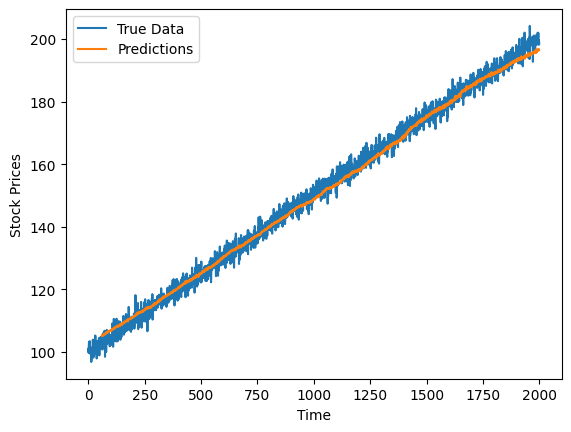

In [7]:
# Make predicitions
predictions = model.predict(X)

# Inverse transform the predictions to get the original scale
predictions = scaler.inverse_transform(predictions)

# plot the predictions
import matplotlib.pyplot as plt

plt.plot(scaler.inverse_transform(data), label='True Data')
plt.plot(np.arange(time_step, time_step + len(predictions)),predictions,label='Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Prices')
plt.legend()
plt.show